In [1]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()

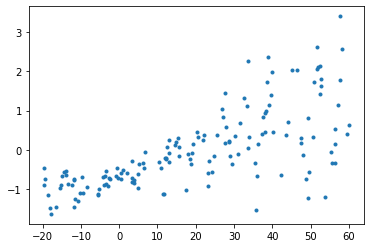

In [2]:
plt.plot(x,y,'.')
plt.show()

In [3]:
len(x)

150

In [4]:
X = torch.tensor(x, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)

- First we&rsquo;ll model a neural network $g_{\theta}(x)$ with maximum likelihood estimation. Where we assume a Gaussian likelihood.
$$\begin{equation}
y \sim \mathcal{N}(g_{\theta}(x), \sigma^2)
\end{equation}$$
$$ \begin{equation}\hat{\theta}_{\text{MLE}} = \text{argmax}_\theta \prod_i^nP(y_i|\theta) \end{equation}$$

In [5]:
class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)

In [6]:
epochs = 200
m = MaximumLikelihood()
optim = torch.optim.Adam(m.parameters(), lr=0.01)

In [7]:
for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = (0.5 * (y_pred - Y)**2).mean()
    loss.backward()
    optim.step()

In [8]:
m.eval()
y_estimate = m(X)

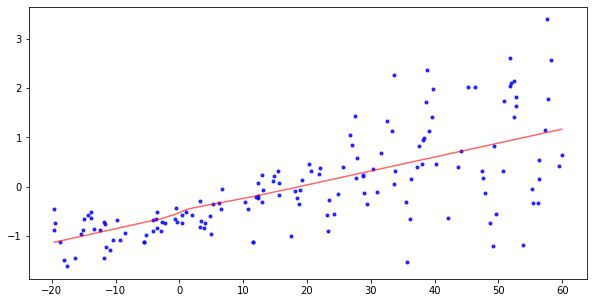

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(x,y, 'b.', alpha=0.8)
plt.plot(x, y_estimate.detach().numpy(), 'r', alpha=0.6)
plt.show()

- We are able to predict the expectation of $y$, but we are not able to make a statement about the uncertainty of our predictions.
- In variational inference, we accept that we cannot obtain the true posterior $P(y|x)$, but we try to approximate this distribution with another distribution $Q_{\theta}(y)$, where $\theta$ are the variational parameters. This distribution we call a variational distribution.
- If we choose a factorized (diagonal) Gaussian variational distribution, we define a function $g_{\theta}: x \mapsto \mu, \sigma$. The function $g_{\theta}$ will be a neural network that predicts the variational parameters. 
- The total model can thus be described as:
$$ \begin{equation}P(y) = \mathcal{N}(0, 1) \end{equation}$$
where we set a unit Gaussian prior $P(y)$.
- from now on we will generalize to a notation that is often used. We&rsquo;ll extend $y|x$ to any (latent) stochastic variable $Z$.

--------------------------------
- Variational inference is done by maximizing the ELBO:
$$ \begin{equation}\text{argmax}_{Z} = E_{Z \sim Q}[\underbrace{\log P(D|Z)}_{\text{likelihood}}] - D_{KL}(Q(Z)||\underbrace{P(Z)}_{\text{prior}}) \label{eq:elbo} \end{equation}$$
- Let's rewrite this ELBO definition so that it is more clear how we can use it to optimize the model.
$$E_{Z \sim Q}[\log P(D|Z)] + E_{Z \sim Q}[ \frac{P(Z)}{Q(Z)}]dZ$$
$$E_{Z \sim Q}[\log P(D|Z)] + E_{Z \sim Q}[\log P(Z) - \log Q(Z)]$$

#### Monte Carlo ELBO and reparameterization trick
- Deriving those expectations maybe not possible, thus we can get estimates of the true expectation by taking samples from $Q(Z)$ and average over those results.
- If we start taking samples from a $Q(Z)$ we leave the deterministic world, and the gradient can not flow through the model anymore. We avoid this problem by reparameterizing the samples from the distribution.
- Instead of sampling directly from the variational distribution, $z \sim Q(\mu, \sigma^2)$, we sample from a unit gaussian and recreate samples from the variational distribution. Now the stochasticity of $\epsilon$ is external and will not prevent the flow of gradients.

In [10]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):        
        sigma = torch.exp(0.5 * log_var) + 1e-5
        epsilon = torch.randn_like(sigma)
        return mu + sigma * epsilon

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

$$ \begin{aligned}  \log p(\mathbf{y}|\mathbf{X, \mu, \sigma}) &= \sum_{i=1}^N \log N(y_i;\mathbf{\mu,\sigma^2}) \\  &= \sum_{i=1}^N \log \frac{1}{\sqrt{2\pi\sigma^2_e}}\exp (-\frac{(y_i - \mathbf{\mu})^2}{2\sigma^2_e}) \\  &= -\frac{N}{2}\log 2\pi\sigma^2_e - \sum_{i=1}^N \frac{(y_i-\mathbf{\mu)^2}}{2\sigma^2_e}  \end{aligned}$$

In [11]:
def ll_gaussian(y, mu, log_var):   #log-likelihood of gaussian
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

In [12]:
def elbo(y_pred, y, mu, log_var):
    # likelihood of observing y given Variational mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # prior probability of y_pred
    log_prior = ll_gaussian(y_pred, 0, torch.log(torch.tensor(1.)))
    
    # variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

In [13]:
def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)

In [14]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

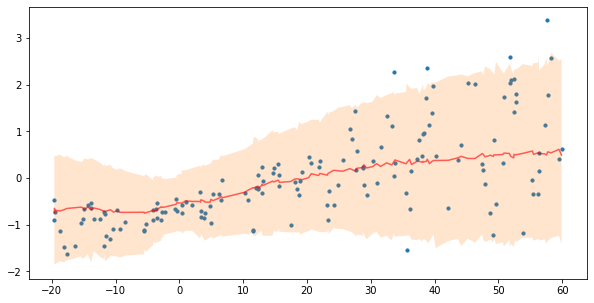

In [32]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=10)
plt.plot(X, mu, 'r', alpha=0.6)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

#### Analytical KL-divergence
- Above we have implemented ELBO by sampling from the variational posterior. It turns out that for the KL-divergence term, this isn’t necessary as there is an analytical solution:
$$D_{KL}(Q(Z)||P(Z)) = \frac{1}{2}\sum_{i=1}^n(1+\log \sigma_i^2 - \mu_i^2 - \sigma_i^2)$$
- For the likelihood term, we did implement Guassian log likelihood, this term can also be replaced with a similar loss functions. For Gaussian likelihood we can use squared mean error loss. 
- We can simplify the loss function as defined below:
```
def det_loss(y, y_pred, mu, log_var):   
    reconstruction_error = (0.5 * (y - y_pred)**2).sum()
    kl_divergence = (-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp()))

    return (reconstruction_error + kl_divergence).sum()
```

#### Aleatoric and epistemic uncertainty
- In the example above we were able to model the *aleatoric uncertainty*. 
- This is the *inherent variance* in the data which we have to accept because the underlaying data generation process is stochastic in nature. (e.g. throwing the dice, cards you get in a poker game)
- Aleatory can have two flavors, being *homoscedastic* and *heteroscedastic*.
    - homoscedastic: For example in the model definition of linear regression $y = X \beta + \epsilon$ we incorporate $\epsilon$ for the noise in the data. In linear regression, $\epsilon$ is not dependent on $X$ and is therefore assumed to be constant.
    - heteroscedastic: If the aleatoric uncertainty is dependent on $X$, we speak of heteroscedastic uncertainty.

- Epistemic uncertainty can be reduced by designing new model, acquiring more data, etc.
- In the above example data has inherent noise which can't be reduced but when we generate model ensemble using dropout and measure only the *model inconsistency*, that epistemic uncertainty is low as shown in below. (because most of the uncertainty comes from aleatoric uncertainty in this case)
<img src=attachment:image.png width=500>
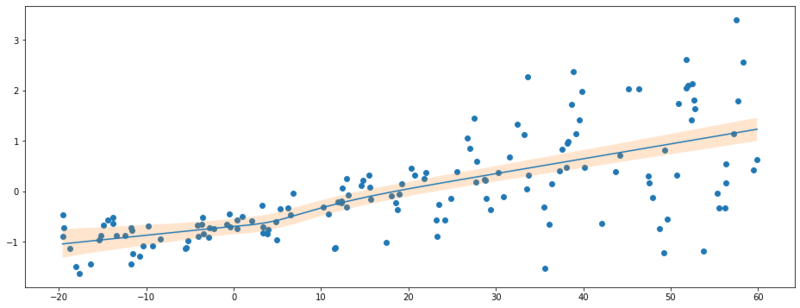